In [ ]:
!pip install split-folders

In [ ]:
import pandas as pd
import os
import zipfile as zf
import splitfolders
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Prepare dataset


In [ ]:
!gdown 1P6lWTRuNl_OqmQR-Yq9XkWXeNaofd1gM

Downloading...
From (original): https://drive.google.com/uc?id=1P6lWTRuNl_OqmQR-Yq9XkWXeNaofd1gM
From (redirected): https://drive.google.com/uc?id=1P6lWTRuNl_OqmQR-Yq9XkWXeNaofd1gM&confirm=t&uuid=36a9b74e-5b95-4502-9a96-60ed2a2a4659
To: /content/trash_images_final-again.zip
100% 134M/134M [00:01<00:00, 112MB/s]


In [ ]:
files = zf.ZipFile("/content/trash_images_final-again.zip",'r')
files.extractall()
files.close()
os.listdir(os.path.join(os.getcwd(),"trash_images_final"))

['metal', 'paper', 'organic', 'glass', 'cardboard', 'plastic']

In [ ]:
splitfolders.ratio("/content/trash_images_final", output="/content/data",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 4607 files [00:00, 5628.76 files/s]


In [ ]:
# Get the paths for the train and validation directories
train_dir = os.path.join(os.getcwd(), "data/train")
val_dir = os.path.join(os.getcwd(), "data/val")

# Get a list of all the folders in the train and validation directories
train_folders = os.listdir(train_dir)
val_folders = os.listdir(val_dir)

# Print the number of directories in each dataset
print(f"Number of directories in train dataset: {len(train_folders)}")
print(f"Number of directories in validation dataset: {len(val_folders)}")

# Print the contents of each folder and the number of files in each folder
print("\nTrain data:")
for folder in train_folders:
  folder_path = os.path.join(train_dir, folder)
  files = os.listdir(folder_path)
  print(f"- {folder}: {len(files)}")

print("\nValidation data:")
for folder in val_folders:
  folder_path = os.path.join(val_dir, folder)
  files = os.listdir(folder_path)
  print(f"- {folder}: {len(files)}")
# Get the paths for the train and validation directories
train_dir = os.path.join(os.getcwd(), "data/train")
val_dir = os.path.join(os.getcwd(), "data/val")

# Get a list of all the folders in the train and validation directories
train_folders = os.listdir(train_dir)
val_folders = os.listdir(val_dir)

total_train = len(list(paths.list_images(train_dir)))
total_val = len(list(paths.list_images(val_dir)))
print("\nTotal training images:", total_train)
print("Total validation images:", total_val)



Number of directories in train dataset: 6
Number of directories in validation dataset: 6

Train data:
- metal: 620
- paper: 603
- organic: 616
- glass: 624
- cardboard: 600
- plastic: 621

Validation data:
- metal: 156
- paper: 151
- organic: 154
- glass: 156
- cardboard: 150
- plastic: 156

Total training images: 3684
Total validation images: 923


# Create Model

In [ ]:
base_model=tf.keras.applications.MobileNet(weights='imagenet',
                                           include_top=False,
                                           input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
model =  tf.keras.models.Sequential([
    base_model,
    tf.keras.models.GlobalAveragePooling2D(),
    tf.keras.models.Dense(1024, activation='relu'),
    tf.keras.models.DenseDropout(0.5),
    tf.keras.models.DenseDense(1024, activation='relu'),
    tf.keras.models.DenseDropout(0.3),
    tf.keras.models.DenseDense(1024, activation='relu'),
    tf.keras.models.DenseDropout(0.2),
    tf.keras.models.DenseDense(6, activation='softmax')
])

In [ ]:
for layer in base_model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1.0/255.
                                    shear_range=0.2,
                                    rotation_range=40,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    zoom_range=0.3,
                                    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen  = ImageDataGenerator( rescale = 1.0/255.,
                                    rotation_range=30,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    zoom_range=0.3,
                                    horizontal_flip=True)

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    target_size=(224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                         batch_size=16,
                                                         class_mode='categorical',
                                                         color_mode='rgb',
                                                         shuffle=False,
                                                         target_size=(224, 224))

Found 3684 images belonging to 6 classes.
Found 923 images belonging to 6 classes.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=['accuracy'])

H = model.fit(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size,
    epochs=60)

Epoch 1/60
230/230 [==============================] - 84s 287ms/step - loss: 1.7768 - accuracy: 0.2655 - val_loss: 1.3208 - val_accuracy: 0.6590
Epoch 2/60
230/230 [==============================] - 70s 302ms/step - loss: 1.3993 - accuracy: 0.4539 - val_loss: 0.9188 - val_accuracy: 0.7774
Epoch 3/60
230/230 [==============================] - 64s 278ms/step - loss: 1.1115 - accuracy: 0.5941 - val_loss: 0.6787 - val_accuracy: 0.8004
Epoch 4/60
230/230 [==============================] - 65s 281ms/step - loss: 0.9049 - accuracy: 0.6682 - val_loss: 0.5326 - val_accuracy: 0.8311
Epoch 5/60
230/230 [==============================] - 62s 270ms/step - loss: 0.7848 - accuracy: 0.7216 - val_loss: 0.4514 - val_accuracy: 0.8465
Epoch 6/60
230/230 [==============================] - 64s 278ms/step - loss: 0.6931 - accuracy: 0.7519 - val_loss: 0.3882 - val_accuracy: 0.8542
Epoch 7/60
230/230 [==============================] - 68s 294ms/step - loss: 0.6437 - accuracy: 0.7617 - val_loss: 0.3537 - val_ac

#Evaluasi Model

Text(0.5, 1.0, 'Training and validation loss')

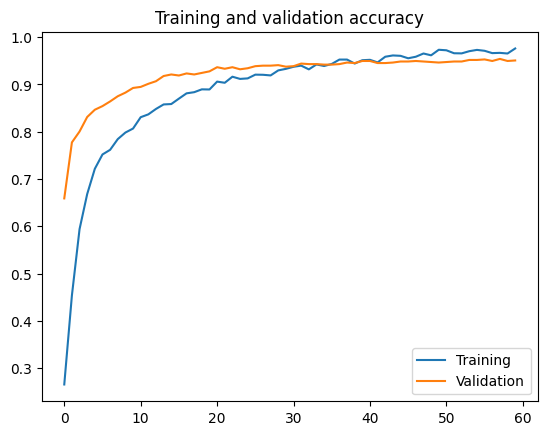

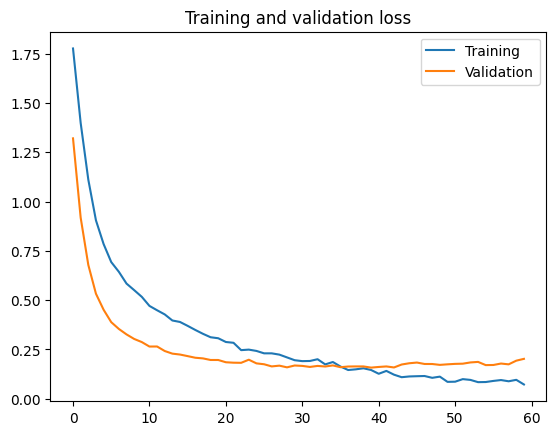

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = H.history[    'accuracy' ]
val_acc  = H.history['val_accuracy' ]
loss     = H.history[    'loss' ]
val_loss = H.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

In [ ]:
# Get the predictions for the validation data
y_pred = model.predict(validation_generator)
# Convert the predictions to class labels
y_pred = np.argmax(y_pred, axis=1)
# Print the classification report
print(classification_report(validation_generator.classes, y_pred))

58/58 [==============================] - 6s 99ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.88      0.94      0.91       156
           2       0.94      0.94      0.94       156
           3       0.99      0.99      0.99       154
           4       0.95      0.97      0.96       151
           5       0.94      0.88      0.91       156

    accuracy                           0.95       923
   macro avg       0.95      0.95      0.95       923
weighted avg       0.95      0.95      0.95       923



#Save Model and Convert Model To Tensorflow Json

In [ ]:
import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.15.0


In [ ]:
pip install tensorflowjs --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 673.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.3 MB/s eta 0:00:00


In [ ]:
# tensorflow.js converter to convert the saved Keras model into JSON format.

saved_model_path = "/content/model_wastify.h5"
!tensorflowjs_converter --input_format=keras {saved_model_path} ./
!zip modelwastify.zip *.bin model.json

2024-06-19 15:27:48.920438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  adding: group1-shard1of7.bin (deflated 8%)
  adding: group1-shard2of7.bin (deflated 8%)
  adding: group1-shard3of7.bin (deflated 8%)
  adding: group1-shard4of7.bin (deflated 7%)
  adding: group1-shard5of7.bin (deflated 7%)
  adding: group1-shard6of7.bin (deflated 7%)
  adding: group1-shard7of7.bin (deflated 7%)
  adding: model.json (deflated 95%)
